In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, ReLU, Concatenate, Activation,ZeroPadding2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import time

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, LeakyReLU, ReLU
from keras.utils import img_to_array, load_img, plot_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
path = "/kaggle/input/pix2pixmap/maps/train/"
num_images = 1096

combined_images = sorted(glob(path + "*.jpg"))[:num_images]    
images = np.zeros(shape=(len(combined_images), 256, 256, 3))
masks = np.zeros(shape=(len(combined_images), 256, 256, 3))

for idx, path in enumerate(combined_images):

    combined_image = tf.cast(img_to_array(load_img(path)), tf.float32)
    
    image = combined_image[:,:600,:]
    mask = combined_image[:,600:,:]

    images[idx] = (tf.image.resize(image,(256,256)))/255
    masks[idx] = (tf.image.resize(mask,(256,256)))/255

In [4]:
print(images.shape)

(1096, 256, 256, 3)


In [5]:
print(masks.shape)

(1096, 256, 256, 3)


In [4]:
def encoder_block(layer_in, filters, is_batch_norm = True, name = 'encoder_block'):
    X = Conv2D(filters, kernel_size= (4,4), strides= (2,2), padding= 'same', kernel_initializer= RandomNormal(stddev= 0.02), name = name+'_conv')(layer_in)
    if is_batch_norm:
        X = BatchNormalization(name = name+'_bn')(X, training = True)
    X = LeakyReLU(alpha = 0.2, name = name +'_activation')(X)
    return X

In [5]:
def decoder_block(layer_in, skip_conn_layer, filters, is_dropout = True, name = 'decoder_block'):
    X = Conv2DTranspose(filters, kernel_size= (4,4), strides= (2,2), padding= 'same', kernel_initializer= RandomNormal(stddev= 0.02), name = name+'_convT')(layer_in)
    X = BatchNormalization(name = name+'_bn')(X, training = True)
    if is_dropout:
        X = Dropout(0.5, name = name+'_dropout')(X, training = True)
    X = Concatenate(name = name +'_concat')([X, skip_conn_layer])
    X = Activation('relu', name = name+'_activation')(X)
    return X

In [6]:
def define_generator(input_shape):
    input = Input(shape = input_shape, name = 'generator_input')

    e1 = encoder_block(input, filters = 64, is_batch_norm= False, name= 'encoder_block_1')
    e2 = encoder_block(e1, filters = 128, name = 'encoder_block_2')
    e3 = encoder_block(e2, filters = 256, name = 'encoder_block_3')
    e4 = encoder_block(e3, filters = 512, name = 'encoder_block_4')
    e5 = encoder_block(e4, filters = 512, name = 'encoder_block_5')
    e6 = encoder_block(e5, filters = 512, name = 'encoder_block_6')
    e7 = encoder_block(e6, filters = 512, name = 'encoder_block_7')

    # bottleneck 
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer= RandomNormal(stddev=0.02), name = 'bottleneck_conv')(e7)
    b = Activation('relu', name= 'bottleneck_activation')(b)

    # decoder model
    d1 = decoder_block(b, skip_conn_layer= e7, filters= 512, name = 'decoder_block_1')
    d2 = decoder_block(d1, skip_conn_layer= e6, filters= 512, name = 'decoder_block_2')
    d3 = decoder_block(d2, skip_conn_layer= e5, filters= 512, name = 'decoder_block_3')
    d4 = decoder_block(d3, skip_conn_layer= e4, filters= 512, is_dropout=False, name = 'decoder_block_4')
    d5 = decoder_block(d4, skip_conn_layer= e3, filters= 256, is_dropout=False, name = 'decoder_block_5')
    d6 = decoder_block(d5, skip_conn_layer= e2, filters= 128, is_dropout= False, name = 'decoder_block_6')
    d7 = decoder_block(d6, skip_conn_layer = e1, filters=64, is_dropout= False, name = 'decoder_block_7')
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02), name = 'output_conv')(d7)
    out_image = Activation('tanh', name= 'output_activation')(g)
    # define model
    model = Model(input, out_image, name ='Generator')
    return model

In [7]:
def discriminator_block(layer_in, filters,stride =2, padding='same', is_batch_norm = True, name = 'discriminator_block'):
    X = Conv2D(filters, kernel_size= (4,4), strides= stride, padding= padding, kernel_initializer= RandomNormal(stddev= 0.02), name = name+'_conv' )(layer_in)
    if is_batch_norm:
        X = BatchNormalization(name = name+'_bn')(X)
    X = LeakyReLU(alpha = 0.2, name = name+'_leakyrelu')(X)
    return X

In [8]:
def define_discriminator(input_shape):
    '''This function takes in shape of image as input and return discriminator model '''
    in_source_image = Input(shape= input_shape, name = 'discriminator_source_image_input')
    in_target_image = Input(shape= input_shape, name = 'discriminator_target_image_input')
    discriminator_input = Concatenate()([in_source_image, in_target_image])

    d1 = discriminator_block(discriminator_input, filters= 64, is_batch_norm= False, name = 'discriminator_block_1')
    d2 = discriminator_block(d1, filters= 128, name = 'discriminator_block_2')
    d3 = discriminator_block(d2, filters = 256, name = 'discriminator_block_3')

    pad1 = ZeroPadding2D(name = 'padding_1')(d3)
    
    d4 = discriminator_block(pad1, filters= 512,stride =1,padding ='valid', name = 'discriminator_block_4')

    pad2 = ZeroPadding2D(name = 'padding_2')(d4)
    
    output_conv = Conv2D(filters= 1, kernel_size= (4,4), kernel_initializer= RandomNormal(stddev= 0.02), name='output_conv')(pad2)
    output = Activation('sigmoid')(output_conv)
    model = Model([in_source_image, in_target_image], output, name ='Discriminator')

    model.compile(loss ='binary_crossentropy', optimizer= Adam(learning_rate= 0.0002, beta_1= 0.5), loss_weights= [0.5])

    return model

In [9]:
gan_losses = []  # List to store generator losses
disc_losses = []
Epochs_total = 150

In [10]:
def define_cgan(generator, discriminator, input_shape):
    for layer in discriminator.layers:
        layer.trainable = False
    
    input_source = Input(shape=input_shape, name = 'cgan_input')

    gen_out = generator(input_source)

    dis_out = discriminator([input_source, gen_out])

    model = Model(input_source, [dis_out, gen_out], name ='CGAN')

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model


In [11]:
sat_images  = images
map_images = masks

In [12]:
def generate_real_samples(sat_images, map_images, batch_size, patch_size):
    sample = np.random.randint(0,sat_images.shape[0],batch_size)
    sample_sat_image = sat_images[sample]
    sample_map_image = map_images[sample]

    y = np.ones((batch_size, patch_size, patch_size, 1))
    y = np.where(y == 1, 0.9, 1)
    return [sample_sat_image, sample_map_image] , y

In [13]:
def generate_fake_samples(sample, generator, patch_size):
    X = generator.predict(sample)
    y = np.zeros((len(X), patch_size, patch_size, 1))
    return X, y

In [14]:
def summarize_performance(epoch, generator, sat_images, map_images, n_samples=3):
    # select a sample of input images
    [X_sat_image_real, X_map_image_real], _ = generate_real_samples(sat_images, map_images, n_samples, 1)
    
    # generate a batch of fake samples
    map_image_generated, _ = generate_fake_samples(X_sat_image_real, generator, 1)

    # scale all pixels from [-1,1] to [0,1]
    X_sat_image_real = (X_sat_image_real + 1) / 2.0
    X_map_image_real = (X_map_image_real + 1) / 2.0
    map_image_generated = (map_image_generated + 1) / 2.0

    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_sat_image_real[i])
    
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(map_image_generated[i])
    
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_map_image_real[i])
    
    filename1 = 'plot_{}.png'.format(epoch)
    plt.savefig(filename1)
    plt.close()
    
    # save the generator model
    #filename2 = 'model_{}.h5'.format(epoch)
    #generator.save(filename2)
    #print('>Saved: %s and %s' % (filename1, filename2))

In [15]:
def train(discriminator, generator, cgan_model, sat_images, map_images, epochs = 150, batch_size = 32):
    patch_size = discriminator.output_shape[1]
    batch_per_epoch = int(len(sat_images)/ batch_size)
    steps = batch_per_epoch*epochs
    ls_gs = 0
    ls_ds = 0
    Epochs_total = epochs
    for epoch in range(epochs):
        print('Epoch: {}/{}'.format(epoch+1, epochs))
        for step in range(batch_per_epoch):
            [X_sat_real, X_map_real],  y_real = generate_real_samples(sat_images, map_images, batch_size, patch_size)
            X_map_fake, y_fake = generate_fake_samples(X_sat_real, generator, patch_size)

            d_loss1 = discriminator.train_on_batch([X_sat_real, X_map_real], y_real)
            d_loss2 = discriminator.train_on_batch([X_sat_real, X_map_fake], y_fake)
            ls_ds = d_loss1 + d_loss2
            g_loss, _, _ = cgan_model.train_on_batch(X_sat_real, [y_real, X_map_real])
            ls_gs = g_loss
            if(step%15==0):
                print(' Batch {}/{} d_loss:{} g_loss :{}'.format(step ,batch_per_epoch, ls_ds, g_loss))
            #if((step+1) % 10 == 0):
            #    print('.',end = '')
            #if((step+1)%100 == 0):
            #    print(' Batch {}/{} d_loss1:{} d_loss2 :{} g_loss :{}'.format(step+1,batch_per_epoch, d_loss1, d_loss2, g_loss))
        
        # summarize model performance every 15 epochs
        gan_losses.append(ls_gs) # List to store generator losses
        disc_losses.append(ls_ds)
    summarize_performance(epoch+1, generator, sat_images, map_images)
            

In [16]:
image_shape = sat_images.shape[1:]

In [17]:
discriminator = define_discriminator(image_shape)
generator = define_generator(image_shape)
cgan = define_cgan(generator, discriminator, image_shape)
#train(discriminator, generator, cgan, sat_images, map_images)

In [20]:
print(gan_losses)

[1.9361385107040405, 1.570426106452942, 1.4306044578552246, 1.4099106788635254, 1.4457056522369385, 1.3638381958007812, 1.2361096143722534, 1.0279505252838135, 0.8349428176879883, 0.7950119972229004, 0.7852346301078796, 0.7639821767807007, 0.793027937412262, 0.7863963842391968, 0.8097490668296814, 0.7890640497207642, 0.782706618309021, 0.9178416132926941, 0.7833857536315918, 0.7796396017074585, 0.7791002988815308, 0.7797180414199829, 0.7792836427688599, 0.778349757194519, 0.7946859002113342, 0.7846186757087708, 0.7755388021469116, 0.797032356262207, 4.3603410720825195, 2.5724446773529053, 2.969602584838867, 3.8423783779144287, 1.1387879848480225, 0.9730815887451172, 0.8037240505218506, 0.7896271347999573, 0.7915165424346924, 0.7664452791213989, 0.7725000381469727, 0.833031177520752, 2.114717721939087, 4.466441631317139, 1.0392489433288574, 0.9008963704109192, 1.1826977729797363, 2.670351028442383, 1.2545490264892578, 1.3962047100067139, 11.515198707580566, 1.4572497606277466, 2.1848528

In [21]:
print(disc_losses)

[0.17944055143743753, 0.17092603747732937, 0.16701805486809462, 0.16570070339366794, 0.16494728781981394, 0.1657899921410717, 0.16633408842608333, 0.16477760602720082, 0.16415059223072603, 0.1639788123429753, 0.16401187592418864, 0.16432850269484334, 0.1636882131861057, 0.16381424156134017, 0.16355921441572718, 0.16361594748013886, 0.16341607594222296, 0.1630485936329933, 0.16301504526200006, 0.16314070762018673, 0.16308029668289237, 0.16324460069154156, 0.16404866456286982, 0.1631239176276722, 0.163177968992386, 0.16367083138902672, 0.16333735876105493, 0.16381782288954128, 0.25354817137122154, 0.1819314081221819, 0.1810703370720148, 0.17914411006495357, 0.18181274738162756, 0.16707080602645874, 0.16656717576552182, 0.16592603956814855, 0.16533506143605337, 0.16389658165280707, 0.16457868448924273, 0.1637263945012819, 0.19279018230736256, 0.17980656493455172, 0.16642405523452908, 0.17354298289865255, 0.1696540059056133, 0.18503728788346052, 0.173220070078969, 0.16813613125123084, 0.22

In [22]:
print(Epochs_total)

150


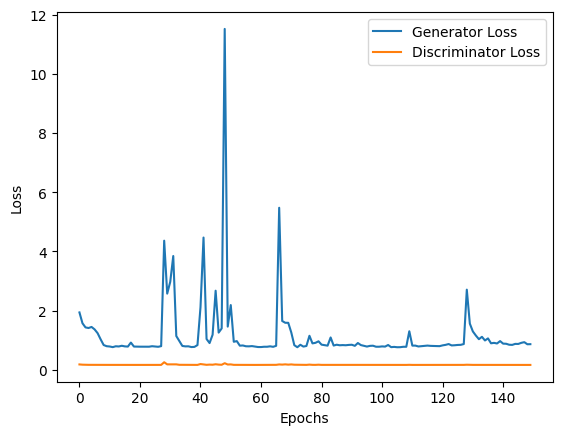

In [23]:
plt.plot(range(150), gan_losses, label="Generator Loss")
plt.plot(range(150), disc_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
filename2 = 'model_CGAN_100.h5'
generator.save(filename2)

In [18]:
generator.load_weights('/kaggle/input/cgan-model/model_CGAN_100.h5')

In [19]:
path_val = "/kaggle/input/pix2pixmap/maps/val/"
num_images_val = 1098

combined_images_val = sorted(glob(path_val + "*.jpg"))[:num_images_val]    
images_val = np.zeros(shape=(len(combined_images_val), 256, 256, 3))
masks_val = np.zeros(shape=(len(combined_images_val), 256, 256, 3))

for idx, path_val in enumerate(combined_images_val):

    combined_image_val = tf.cast(img_to_array(load_img(path_val)), tf.float32)
    
    image_val = combined_image_val[:,:600,:]
    mask_val = combined_image_val[:,600:,:]

    images_val[idx] = (tf.image.resize(image_val,(256,256)))/255
    masks_val[idx] = (tf.image.resize(mask_val,(256,256)))/255

In [20]:
len(images_val)

1098

In [21]:
actual = []
fake = []

In [22]:
def show_predictions(num_samples):
    for i in range(num_samples):
        idx = np.random.randint(images.shape[0])
        image, mask = images_val[idx], masks_val[idx]
        predicted = generator.predict(tf.expand_dims(image, axis=0))[0]

        plt.figure(figsize=(10,8))
        
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Satellite Image " + str(i + 1))
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title("Map Image " + str(i + 1))
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.imshow(predicted)
        plt.title("Predicted Image " + str(i + 1))
        plt.axis('off')
        
        plt.show()

In [23]:
def predictions():
    for i in range(0,1098):
        #idx = np.random.randint(images.shape[0])
        image, mask = images_val[i], masks_val[i]
        actual.append(mask)
        predicted = generator.predict(tf.expand_dims(image, axis=0))[0]
        fake.append(predicted)

In [25]:
predictions()

1/1 [==============================] - 0s 25ms/step


In [26]:
#import numpy as np
from keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from scipy.linalg import sqrtm
from numpy import iscomplexobj
from tensorflow.keras.models import Model

# Load ResNet50 model without the final classification layer
base_model = ResNet50(weights='imagenet', input_shape=(256, 256, 3), include_top=False, pooling='avg')

# Function to preprocess images for ResNet50
def preprocess_images(images):
    images = np.array([image.img_to_array(img) for img in images])
    images = tf.keras.applications.resnet50.preprocess_input(images)
    return images

# Function to calculate FID
def calculate_fid(images1, images2):
    # Preprocess images
    images1 = preprocess_images(images1)
    images2 = preprocess_images(images2)

    # Generate feature representations
    features1 = base_model.predict(images1)
    features2 = base_model.predict(images2)

    # Calculate mean and covariance statistics
    mu1, sigma1 = np.mean(features1, axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = np.mean(features2, axis=0), np.cov(features2, rowvar=False)

    # Calculate FID
    sum_squared_diff = np.sum((mu1 - mu2)**2)
    cov_mean_sqrt = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(cov_mean_sqrt):
        cov_mean_sqrt = cov_mean_sqrt.real
    fid = sum_squared_diff + np.trace(sigma1 + sigma2 - 2.0 * cov_mean_sqrt)

    return fid

# Example usage
# images_set1 and images_set2 should be numpy arrays with images of shape (num_images, 256, 256, 3)
print(len(actual))
print(len(fake))
fid_score = calculate_fid(actual, fake)
print(f"FID Score: {fid_score}")


94765736/94765736 [==============================] - 4s 0us/step
1098
1098
35/35 [==============================] - 2s 59ms/step
FID Score: 0.6348489560052787
